In [6]:
%matplotlib inline
import pandas as pd

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


ImportError: cannot import name _thread

In [3]:
df = pd.DataFrame.from_csv("../data/train_risk.csv")
test = pd.DataFrame.from_csv("../data/test_risk.csv")

In [4]:
X, y = df[df.columns[:-1]], df[df.columns[-1]]

In [5]:
X['AGE']

DGN
3    49
3    72
3    51
3    72
3    69
3    68
3    59
2    56
3    55
3    64
3    64
3    60
2    70
3    54
3    56
3    54
3    73
3    55
3    66
5    61
3    64
3    69
3    65
4    58
3    53
4    38
3    64
4    59
3    74
5    59
     ..
3    49
3    77
2    70
3    53
3    67
2    59
3    60
3    55
3    66
2    64
3    54
3    49
4    64
3    58
3    55
3    54
3    71
5    57
4    72
3    63
2    55
3    72
3    54
2    64
4    80
3    64
3    60
3    66
3    62
3    62
Name: AGE, dtype: int64

In [175]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

rf = RandomForestClassifier()
skf = StratifiedKFold(y, n_folds=5)
cross_val_score(rf, X, y, cv=skf).mean()

0.76353153653792727

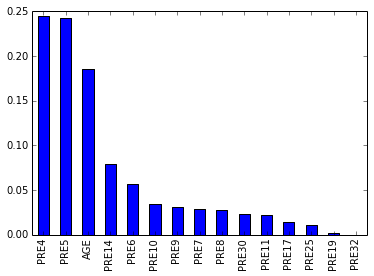

In [139]:
X = pd.DataFrame(StandardScaler().fit_transform(X), columns=df.columns[:-1], index=df.index)
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importance.plot(kind='bar')

In [177]:
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt

top_vars = df[feature_importance[:3].index]
mask = top_vars['PRE5'] < 40
top_vars = top_vars.loc[mask]
top_y = y.loc[mask]
# top_vars.plot(kind='scatter', x=0, y=1, c=top_y)

plot = plt.figure().gca(projection='3d')
plot.scatter(*top_vars.T.as_matrix(), c=top_y)
plot.set_xlabel(df.columns[0])
plot.set_ylabel(df.columns[1])
plot.set_zlabel(df.columns[2])
plt.show()

In [190]:
rf = RandomForestClassifier()
skf = StratifiedKFold(top_y, n_folds=5)
cross_val_score(rf, top_vars, top_y, cv=skf).mean()

0.77157300029735354